# Подготовка на средата

In [ ]:
!cd data && unzip 'data.zip'

Archive:  data.zip
   creating: 168/
  inflating: 168/3.txt               
  inflating: 168/6.txt               
  inflating: 168/30.txt              
  inflating: 168/11.txt              
  inflating: 168/22.txt              
  inflating: 168/4.txt               
  inflating: 168/15.txt              
  inflating: 168/5.txt               
  inflating: 168/17.txt              
  inflating: 168/13.txt              
  inflating: 168/10.txt              
  inflating: 168/28.txt              
  inflating: 168/18.txt              
  inflating: 168/1.txt               
  inflating: 168/24.txt              
  inflating: 168/19.txt              
  inflating: 168/8.txt               
  inflating: 168/16.txt              
  inflating: 168/20.txt              
  inflating: 168/12.txt              
  inflating: 168/26.txt              
  inflating: 168/23.txt              
  inflating: 168/21.txt              
  inflating: 168/7.txt               
  inflating: 168/14.txt              
  inflating: 

In [83]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 4.4 MB/s 


In [85]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import seaborn as sn

from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# Подготовка на модела и данните

In [ ]:
class ArticleDataset(torch.utils.data.Dataset):
    def __init__(self, data, label_mapping):
        self.__data = data
        self.__label_mapping = label_mapping

    def __len__(self):
        return self.__data.shape[0]

    def __getitem__(self, idx):
        row = self.__data.iloc[idx]

        target_label = row['idealogyLabel']
        article_text_location = row['articleText']

        with open(os.path.join('data', article_text_location)) as fp:
            article_text = fp.read()

        return article_text, self.__label_mapping[target_label]

In [73]:
# Model itself
class ArticleProfilerModel(nn.Module):
    def __init__(self, dropout=0.5, amount_of_categories=9):
        super(ArticleProfilerModel, self).__init__()

        self.__tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        self.__model = BertModel.from_pretrained("bert-base-multilingual-cased").to('cuda')

        self.__dropout = nn.Dropout(dropout).to('cuda')
        
        self.__linear = nn.Linear(768, amount_of_categories).to('cuda')
        self.__relu = nn.ReLU().to('cuda')
        
    def forward(self, text):
        encoded_input = self.__tokenizer(text, return_tensors='pt', 
                                         truncation=True, padding='max_length').to('cuda')
        output = self.__model(**encoded_input).pooler_output.to('cuda')

        dropout_output = self.__dropout(output).to('cuda')

        linear_output = self.__linear(dropout_output).to('cuda')
        final_output = self.__relu(linear_output).to('cuda')

        return final_output

In [74]:
# Train & Test loop
def train_loop(model, train_dataloader, epochs, loss_fn, optimizer):
    for epoch in range(epochs):
        size = len(train_dataloader.dataset)
        print(f'Epoch {epoch}')
        for batch, (X, y) in tqdm(enumerate(train_dataloader)):
            prediction = model(X)
            y = y.to('cuda')

            loss = loss_fn(prediction, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(model, dataloader, loss_fn):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0

        with torch.no_grad():
            for X, y in dataloader:
                pred = model(X)
                y = y.to('cuda')
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
# Metrics calculations
def confusion_matrix(model, dataloader, label_map):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0

        y_predicted = []
        y_actual = []

        with torch.no_grad():
            for X, y in dataloader:
                pred = model(X)
                y = y.to('cuda')

                y_predicted.append((pred.argmax(1)).type(torch.int).item())
                y_actual.append(y.item())

        y_predicted = [label_map[val] for val in y_predicted]
        y_actual = [label_map[val] for val in y_actual]

        data = {
            'y_actual': y_actual, 
            'y_predicted': y_predicted
        }

        df = pd.DataFrame(data, columns=['y_actual','y_predicted'])
        return pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])

def calculate_metrics(matrix):
    tp_total = 0
    tn_total = 0
    fp_total = 0
    fn_total = 0

    for idx, row in enumerate(matrix):
        tp = matrix[row][row]
        fp = matrix[row].sum() - matrix[row][row]
        fn = matrix.iloc[idx].sum() - matrix[row][row]
        tn = matrix.sum().sum() - tp - fp - fn

        tp_total += tp
        tn_total += tn
        fp_total += fp
        fn_total += fn
        
    return tp_total, tn_total, fp_total, fn_total

In [75]:
# Running the model with normal labels 
full_data = pd.read_csv(os.path.join('data', 'full_data.csv'))
train_data, test_data = train_test_split(full_data, random_state=RANDOM_STATE)

label_mapping = {item: index for index, item in enumerate(full_data['idealogyLabel'].value_counts().keys())}
label_revmapping = {index: item for index, item in enumerate(full_data['idealogyLabel'].value_counts().keys())}

train_dataset = ArticleDataset(train_data, label_mapping)
train_dataloader = DataLoader(train_dataset, batch_size=2)

test_dataset = ArticleDataset(test_data, label_mapping)
test_dataloader = DataLoader(test_dataset, batch_size=2)

model = ArticleProfilerModel(amount_of_categories=len(label_mapping))

learning_rate = 1e-5
optimizer = Adam(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [76]:
train_loop(model, train_dataloader, epochs=15, loss_fn=nn.CrossEntropyLoss(), optimizer=optimizer)

Epoch 0


1it [00:00,  5.69it/s]

loss: 2.221405  [    0/ 1000]


102it [00:16,  6.47it/s]

loss: 2.093501  [  200/ 1000]


202it [00:32,  6.22it/s]

loss: 1.588262  [  400/ 1000]


302it [00:47,  6.23it/s]

loss: 0.746441  [  600/ 1000]


402it [01:03,  6.14it/s]

loss: 1.796613  [  800/ 1000]


500it [01:19,  6.32it/s]


Epoch 1


1it [00:00,  5.93it/s]

loss: 2.187590  [    0/ 1000]


102it [00:16,  6.45it/s]

loss: 0.932652  [  200/ 1000]


202it [00:31,  6.22it/s]

loss: 0.362938  [  400/ 1000]


302it [00:47,  6.23it/s]

loss: 0.322438  [  600/ 1000]


402it [01:03,  6.18it/s]

loss: 1.074939  [  800/ 1000]


500it [01:18,  6.35it/s]


Epoch 2


1it [00:00,  5.82it/s]

loss: 2.134324  [    0/ 1000]


102it [00:16,  6.49it/s]

loss: 0.939971  [  200/ 1000]


202it [00:31,  6.20it/s]

loss: 0.114145  [  400/ 1000]


302it [00:47,  6.21it/s]

loss: 0.384963  [  600/ 1000]


402it [01:03,  6.15it/s]

loss: 0.989244  [  800/ 1000]


500it [01:18,  6.34it/s]


Epoch 3


1it [00:00,  5.84it/s]

loss: 1.526951  [    0/ 1000]


102it [00:16,  6.46it/s]

loss: 0.633834  [  200/ 1000]


202it [00:31,  6.20it/s]

loss: 0.478276  [  400/ 1000]


302it [00:47,  6.18it/s]

loss: 0.200643  [  600/ 1000]


402it [01:03,  6.12it/s]

loss: 0.728233  [  800/ 1000]


500it [01:18,  6.33it/s]


Epoch 4


1it [00:00,  5.89it/s]

loss: 0.908150  [    0/ 1000]


102it [00:16,  6.47it/s]

loss: 0.856470  [  200/ 1000]


202it [00:31,  6.24it/s]

loss: 0.051220  [  400/ 1000]


302it [00:47,  6.24it/s]

loss: 0.367351  [  600/ 1000]


402it [01:03,  6.19it/s]

loss: 0.642992  [  800/ 1000]


500it [01:18,  6.35it/s]


Epoch 5


1it [00:00,  5.95it/s]

loss: 0.249113  [    0/ 1000]


102it [00:16,  6.49it/s]

loss: 0.857827  [  200/ 1000]


202it [00:31,  6.25it/s]

loss: 0.046103  [  400/ 1000]


302it [00:47,  6.25it/s]

loss: 0.254554  [  600/ 1000]


402it [01:03,  6.16it/s]

loss: 0.669407  [  800/ 1000]


500it [01:18,  6.35it/s]


Epoch 6


1it [00:00,  5.91it/s]

loss: 0.252998  [    0/ 1000]


102it [00:16,  6.50it/s]

loss: 0.868881  [  200/ 1000]


202it [00:31,  6.20it/s]

loss: 0.025692  [  400/ 1000]


302it [00:47,  6.21it/s]

loss: 0.197117  [  600/ 1000]


402it [01:03,  6.18it/s]

loss: 0.643350  [  800/ 1000]


500it [01:18,  6.35it/s]


Epoch 7


1it [00:00,  5.75it/s]

loss: 0.063100  [    0/ 1000]


102it [00:16,  6.48it/s]

loss: 0.839746  [  200/ 1000]


202it [00:31,  6.26it/s]

loss: 0.024217  [  400/ 1000]


302it [00:47,  6.22it/s]

loss: 0.113117  [  600/ 1000]


402it [01:03,  6.16it/s]

loss: 0.680787  [  800/ 1000]


500it [01:18,  6.34it/s]


Epoch 8


1it [00:00,  5.78it/s]

loss: 0.037902  [    0/ 1000]


102it [00:16,  6.43it/s]

loss: 0.680877  [  200/ 1000]


202it [00:32,  6.25it/s]

loss: 0.021868  [  400/ 1000]


302it [00:47,  6.22it/s]

loss: 0.240722  [  600/ 1000]


402it [01:03,  6.19it/s]

loss: 0.669535  [  800/ 1000]


500it [01:19,  6.33it/s]


Epoch 9


1it [00:00,  5.87it/s]

loss: 0.036379  [    0/ 1000]


102it [00:16,  6.49it/s]

loss: 0.499643  [  200/ 1000]


202it [00:31,  6.24it/s]

loss: 0.031253  [  400/ 1000]


302it [00:47,  6.21it/s]

loss: 0.220450  [  600/ 1000]


402it [01:03,  6.17it/s]

loss: 0.749545  [  800/ 1000]


500it [01:18,  6.35it/s]


Epoch 10


1it [00:00,  5.94it/s]

loss: 0.022570  [    0/ 1000]


102it [00:16,  6.48it/s]

loss: 0.693457  [  200/ 1000]


202it [00:31,  6.23it/s]

loss: 0.019034  [  400/ 1000]


302it [00:47,  6.24it/s]

loss: 0.214845  [  600/ 1000]


402it [01:03,  6.19it/s]

loss: 0.620500  [  800/ 1000]


500it [01:18,  6.35it/s]


Epoch 11


1it [00:00,  5.86it/s]

loss: 0.025931  [    0/ 1000]


102it [00:16,  6.49it/s]

loss: 1.373228  [  200/ 1000]


202it [00:31,  6.21it/s]

loss: 0.012934  [  400/ 1000]


302it [00:47,  6.25it/s]

loss: 0.252184  [  600/ 1000]


402it [01:03,  6.19it/s]

loss: 0.740830  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 12


1it [00:00,  5.98it/s]

loss: 0.016334  [    0/ 1000]


102it [00:16,  6.49it/s]

loss: 0.754473  [  200/ 1000]


202it [00:31,  6.26it/s]

loss: 0.009969  [  400/ 1000]


302it [00:47,  6.17it/s]

loss: 0.124425  [  600/ 1000]


402it [01:03,  6.15it/s]

loss: 0.570213  [  800/ 1000]


500it [01:18,  6.35it/s]


Epoch 13


1it [00:00,  5.77it/s]

loss: 0.024195  [    0/ 1000]


102it [00:16,  6.47it/s]

loss: 0.784856  [  200/ 1000]


202it [00:31,  6.25it/s]

loss: 0.023980  [  400/ 1000]


302it [00:47,  6.23it/s]

loss: 0.066158  [  600/ 1000]


402it [01:03,  6.19it/s]

loss: 0.483878  [  800/ 1000]


500it [01:18,  6.35it/s]


Epoch 14


1it [00:00,  5.90it/s]

loss: 0.016157  [    0/ 1000]


102it [00:16,  6.48it/s]

loss: 0.652581  [  200/ 1000]


202it [00:31,  6.22it/s]

loss: 0.012105  [  400/ 1000]


302it [00:47,  6.25it/s]

loss: 0.074977  [  600/ 1000]


402it [01:03,  6.18it/s]

loss: 0.617419  [  800/ 1000]


500it [01:18,  6.35it/s]


In [156]:
torch.save(model.state_dict(), 'newsArticleProfiling_final.model')

In [77]:
test_loop(model, test_dataloader, loss_fn=nn.CrossEntropyLoss())

Test Error: 
 Accuracy: 64.1%, Avg loss: 1.037369 



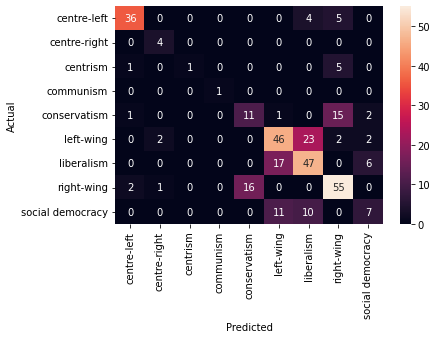

In [142]:
confusion_matrix_obj = confusion_matrix(model, DataLoader(test_dataset, batch_size=1), label_revmapping)
sn.heatmap(confusion_matrix_obj, annot=True)
plt.show()

In [146]:
tp, tn, fp, fn = calculate_metrics(confusion_matrix_obj)

print(f'Accuracy = {(tp + tn) / (tp + tn + fp + fn)}')

precision = tp / (tp + fp)
print(f'Precision = {precision}')

recall = tp / (tp + fn)
print(f'Recall = {recall}')

print(f'F1 = {2 * precision * recall / (precision + recall)}')

Accuracy = 0.9161676646706587
Precision = 0.6227544910179641
Recall = 0.6227544910179641
F1 = 0.6227544910179641


# Reduced labels (left, centre, right)

In [151]:
full_data_simple_labels = pd.read_csv(os.path.join('data', 'full_data.csv'))

simplify_label_map = {
    'centre-left': 'centre',
    'centre-right': 'centre',
    'centrism': 'centre',
    'communism': 'left',
    'conservatism': 'right',
    'left-wing': 'left',
    'liberalism': 'left',
    'right-wing': 'right',
    'social democracy': 'right'
}
full_data_simple_labels['idealogyLabel'] = full_data_simple_labels['idealogyLabel'].map(lambda idealogy: simplify_label_map[idealogy])
print(full_data_simple_labels.head())

train_data_simple_labels, test_data_simple_labels = train_test_split(full_data_simple_labels, random_state=RANDOM_STATE)

label_mapping_simple_labels = {item: index for index, item in enumerate(full_data_simple_labels['idealogyLabel'].value_counts().keys())}
label_revmapping_simple_labels = {index: item for index, item in enumerate(full_data_simple_labels['idealogyLabel'].value_counts().keys())}

train_dataset_simple_labels = ArticleDataset(train_data_simple_labels, label_mapping_simple_labels)
train_dataloader_simple_labels = DataLoader(train_dataset_simple_labels, batch_size=2)

test_dataset_simple_labels = ArticleDataset(test_data_simple_labels, label_mapping_simple_labels)
test_dataloader_simple_labels = DataLoader(test_dataset_simple_labels, batch_size=2)

model_simple_labels = ArticleProfilerModel(amount_of_categories=len(label_mapping_simple_labels))

learning_rate = 1e-5
optimizer = Adam(model_simple_labels.parameters(), lr=learning_rate)

  newspaperLabel      articleText idealogyLabel
0      Habertürk  haberturk/1.txt         right
1      Habertürk  haberturk/2.txt         right
2      Habertürk  haberturk/3.txt         right
3      Habertürk  haberturk/4.txt         right
4      Habertürk  haberturk/5.txt         right


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [152]:
train_loop(model_simple_labels, train_dataloader_simple_labels, epochs=15, loss_fn=nn.CrossEntropyLoss(), optimizer=optimizer)

Epoch 0


1it [00:00,  5.73it/s]

loss: 0.983206  [    0/ 1000]


102it [00:16,  6.51it/s]

loss: 0.705555  [  200/ 1000]


202it [00:31,  6.23it/s]

loss: 0.474154  [  400/ 1000]


302it [00:47,  6.26it/s]

loss: 0.145959  [  600/ 1000]


402it [01:03,  6.18it/s]

loss: 1.021260  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 1


1it [00:00,  5.93it/s]

loss: 1.283157  [    0/ 1000]


102it [00:16,  6.46it/s]

loss: 0.051659  [  200/ 1000]


202it [00:31,  6.24it/s]

loss: 0.368812  [  400/ 1000]


302it [00:47,  6.24it/s]

loss: 0.018525  [  600/ 1000]


402it [01:03,  6.19it/s]

loss: 0.737489  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 2


1it [00:00,  5.94it/s]

loss: 2.059179  [    0/ 1000]


102it [00:16,  6.48it/s]

loss: 0.027025  [  200/ 1000]


202it [00:31,  6.21it/s]

loss: 0.161471  [  400/ 1000]


302it [00:47,  6.25it/s]

loss: 0.020016  [  600/ 1000]


402it [01:03,  6.18it/s]

loss: 0.455827  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 3


1it [00:00,  5.85it/s]

loss: 0.649301  [    0/ 1000]


102it [00:16,  6.47it/s]

loss: 0.008140  [  200/ 1000]


202it [00:31,  6.14it/s]

loss: 0.048886  [  400/ 1000]


302it [00:47,  6.25it/s]

loss: 0.022332  [  600/ 1000]


402it [01:03,  6.19it/s]

loss: 0.671594  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 4


1it [00:00,  5.83it/s]

loss: 0.130573  [    0/ 1000]


102it [00:16,  6.49it/s]

loss: 0.004602  [  200/ 1000]


202it [00:31,  6.26it/s]

loss: 0.015634  [  400/ 1000]


302it [00:47,  6.25it/s]

loss: 0.005532  [  600/ 1000]


402it [01:03,  6.20it/s]

loss: 0.647709  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 5


1it [00:00,  5.83it/s]

loss: 0.059011  [    0/ 1000]


102it [00:16,  6.48it/s]

loss: 0.006677  [  200/ 1000]


202it [00:31,  6.24it/s]

loss: 0.015405  [  400/ 1000]


302it [00:47,  6.26it/s]

loss: 0.008183  [  600/ 1000]


402it [01:03,  6.19it/s]

loss: 0.422429  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 6


1it [00:00,  5.93it/s]

loss: 0.062740  [    0/ 1000]


102it [00:16,  6.50it/s]

loss: 0.003961  [  200/ 1000]


202it [00:31,  6.26it/s]

loss: 0.007182  [  400/ 1000]


302it [00:47,  6.24it/s]

loss: 0.003492  [  600/ 1000]


402it [01:03,  6.17it/s]

loss: 0.631673  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 7


1it [00:00,  5.83it/s]

loss: 0.027797  [    0/ 1000]


102it [00:16,  6.48it/s]

loss: 0.002695  [  200/ 1000]


202it [00:31,  6.25it/s]

loss: 0.004625  [  400/ 1000]


302it [00:47,  6.25it/s]

loss: 0.002907  [  600/ 1000]


402it [01:03,  6.19it/s]

loss: 0.506657  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 8


1it [00:00,  5.90it/s]

loss: 0.008970  [    0/ 1000]


102it [00:16,  6.48it/s]

loss: 0.001739  [  200/ 1000]


202it [00:31,  6.21it/s]

loss: 0.003414  [  400/ 1000]


302it [00:47,  6.25it/s]

loss: 0.002327  [  600/ 1000]


402it [01:03,  6.18it/s]

loss: 0.766928  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 9


1it [00:00,  5.93it/s]

loss: 0.007552  [    0/ 1000]


102it [00:16,  6.47it/s]

loss: 0.003124  [  200/ 1000]


202it [00:31,  6.23it/s]

loss: 0.002619  [  400/ 1000]


302it [00:47,  6.21it/s]

loss: 0.002456  [  600/ 1000]


402it [01:03,  6.18it/s]

loss: 0.484104  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 10


1it [00:00,  5.86it/s]

loss: 0.005934  [    0/ 1000]


102it [00:16,  6.47it/s]

loss: 0.002809  [  200/ 1000]


202it [00:31,  6.25it/s]

loss: 0.002760  [  400/ 1000]


302it [00:47,  6.27it/s]

loss: 0.002421  [  600/ 1000]


402it [01:03,  6.15it/s]

loss: 0.527674  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 11


1it [00:00,  5.91it/s]

loss: 0.007895  [    0/ 1000]


102it [00:16,  6.48it/s]

loss: 0.001757  [  200/ 1000]


202it [00:31,  6.22it/s]

loss: 0.003884  [  400/ 1000]


302it [00:47,  6.19it/s]

loss: 0.002501  [  600/ 1000]


402it [01:03,  6.18it/s]

loss: 0.766282  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 12


1it [00:00,  5.92it/s]

loss: 0.066399  [    0/ 1000]


102it [00:16,  6.48it/s]

loss: 0.002692  [  200/ 1000]


202it [00:31,  6.21it/s]

loss: 0.003860  [  400/ 1000]


302it [00:47,  6.24it/s]

loss: 0.018144  [  600/ 1000]


402it [01:03,  6.19it/s]

loss: 0.549065  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 13


1it [00:00,  5.89it/s]

loss: 0.004819  [    0/ 1000]


102it [00:16,  6.47it/s]

loss: 0.002417  [  200/ 1000]


202it [00:31,  6.23it/s]

loss: 0.001935  [  400/ 1000]


302it [00:47,  6.26it/s]

loss: 0.001415  [  600/ 1000]


402it [01:03,  6.19it/s]

loss: 0.764240  [  800/ 1000]


500it [01:18,  6.36it/s]


Epoch 14


1it [00:00,  5.87it/s]

loss: 0.009748  [    0/ 1000]


102it [00:16,  6.49it/s]

loss: 0.001696  [  200/ 1000]


202it [00:31,  6.25it/s]

loss: 0.003143  [  400/ 1000]


302it [00:47,  6.26it/s]

loss: 0.001471  [  600/ 1000]


402it [01:03,  6.20it/s]

loss: 0.411207  [  800/ 1000]


500it [01:18,  6.36it/s]


In [153]:
test_loop(model_simple_labels, test_dataloader_simple_labels, loss_fn=nn.CrossEntropyLoss())

Test Error: 
 Accuracy: 87.1%, Avg loss: 0.402819 



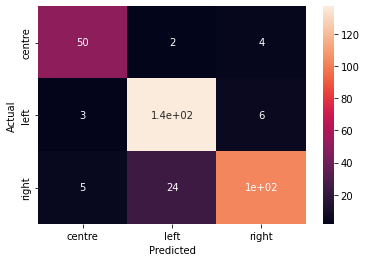

In [154]:
confusion_matrix_simple_labels = confusion_matrix(model_simple_labels, DataLoader(test_dataset_simple_labels, batch_size=1), label_revmapping_simple_labels)
sn.heatmap(confusion_matrix_simple_labels, annot=True)
plt.show()

In [155]:
tp, tn, fp, fn = calculate_metrics(confusion_matrix_simple_labels)

print(f'Accuracy = {(tp + tn) / (tp + tn + fp + fn)}')

precision = tp / (tp + fp)
print(f'Precision = {precision}')

recall = tp / (tp + fn)
print(f'Recall = {recall}')

print(f'F1 = {2 * precision * recall / (precision + recall)}')

Accuracy = 0.9121756487025948
Precision = 0.8682634730538922
Recall = 0.8682634730538922
F1 = 0.8682634730538922


In [157]:
torch.save(model_simple_labels.state_dict(), 'newsArticleProfiling_final_simple_labels.model')